In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import networkx as nx
import torch
import torch.nn as nn

# Load data and skip the first row
arrhythmia_df = pd.read_csv('/kaggle/input/cardiac-arrhythmia-database/data_arrhythmia.csv', header=None, skiprows=1)
arrhythmia_df = arrhythmia_df.iloc[:, 0].str.split(';', expand=True)

# Define core column names and generate pulse columns (AA to LG)
core_columns = ['age', 'sex', 'height', 'weight', 'qrs_duration', 'p-r_interval', 'q-t_interval', 
                't_interval', 'p_interval', 'qrs', 'T', 'P', 'QRST', 'J', 'heart_rate', 'q_wave', 
                'r_wave', 's_wave', "R'_wave", "S'_wave", 'diagnosis']
pulse_columns = [chr(i) + chr(j) for i in range(ord('A'), ord('L') + 1) for j in range(ord('A'), ord('Z') + 1)]
pulse_columns = pulse_columns[:len(arrhythmia_df.columns) - len(core_columns)]

# Assign column names
arrhythmia_df.columns = core_columns + pulse_columns

# Convert all columns to numeric, handling non-numeric errors as NaN
arrhythmia_df = arrhythmia_df.apply(pd.to_numeric, errors='coerce')

# Display unique values in diagnosis for verification
print("Unique diagnosis values:\n", arrhythmia_df['diagnosis'].unique())

# Map diagnosis to descriptive labels
diagnosis_mapping = {
    1: "Normal", 2: "Ischemic Changes", 3: "Old Anterior MI", 4: "Old Inferior MI",
    5: "Sinus Tachycardy", 6: "Sinus Bradycardy", 7: "Ventricular Premature Contraction (PVC)",
    8: "Supraventricular Premature Contraction", 9: "Left Bundle Branch Block", 
    10: "Right Bundle Branch Block", 11: "1st Degree AV Block", 12: "2nd Degree AV Block", 
    13: "3rd Degree AV Block", 14: "Left Ventricle Hypertrophy", 
    15: "Atrial Fibrillation or Flutter", 16: "Others"
}
arrhythmia_df['diagnosis_mapped'] = arrhythmia_df['diagnosis'].map(diagnosis_mapping).fillna("Unknown")

# Diagnosis counts for visualization
diagnosis_counts = arrhythmia_df['diagnosis_mapped'].value_counts()
print("Diagnosis counts:\n", diagnosis_counts)

# Confirm the data structure after adding `pulse_vector`
print(arrhythmia_df[core_columns + ['diagnosis_mapped']].head())
print("\nSample of pulse vectors:\n", arrhythmia_df[pulse_columns].head())

Unique diagnosis values:
 [ 32  24  48  28  20  36  40  44  16   0 100  60  56  12  52  68   8  84]
Diagnosis counts:
 diagnosis_mapped
Unknown                                   441
Others                                      8
2nd Degree AV Block                         2
Supraventricular Premature Contraction      1
Name: count, dtype: int64
   age  sex  height  weight  qrs_duration  p-r_interval  q-t_interval  \
0   75    0     190      80            91           193           371   
1   56    1     165      64            81           174           401   
2   54    0     172      95           138           163           386   
3   55    0     175      94           100           202           380   
4   75    0     190      80            88           181           360   

   t_interval  p_interval  qrs  ...  QRST     J  heart_rate  q_wave  r_wave  \
0         174         121  -16  ...  -2.0   NaN        63.0       0      52   
1         149          39   25  ...  31.0   NaN        53

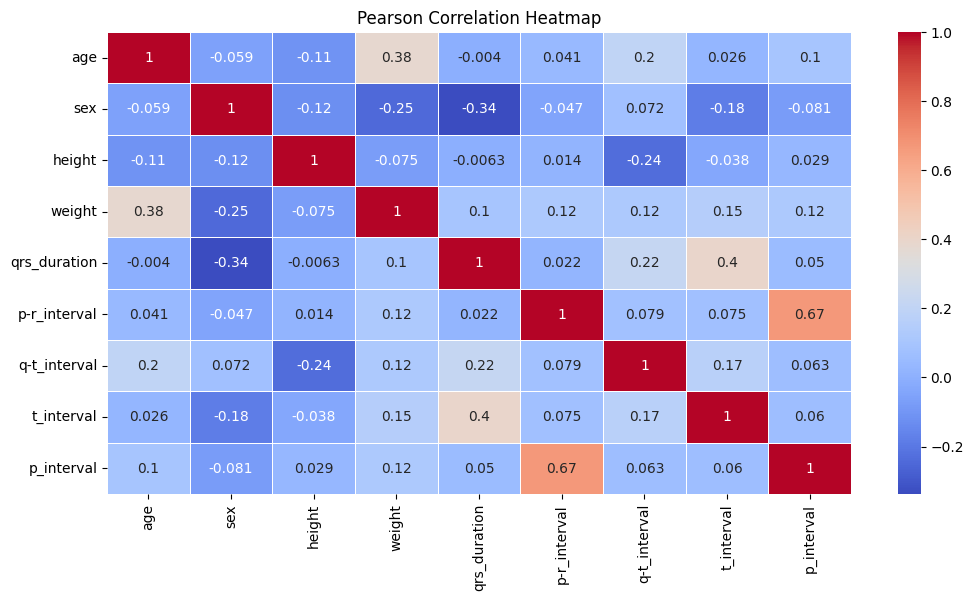

In [2]:
# Feature correlation analysis
selected_features = ['age', 'sex', 'height', 'weight', 'qrs_duration', 'p-r_interval', 
                     'q-t_interval', 't_interval', 'p_interval']
pearson_corr = arrhythmia_df[selected_features].corr(method='pearson')

# Visualize Pearson correlation matrix
plt.figure(figsize=(12, 6))
sns.heatmap(pearson_corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Pearson Correlation Heatmap")
plt.show()

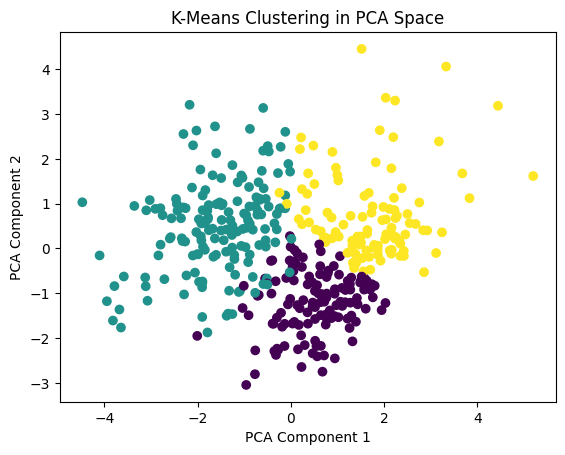

In [3]:
# Outlier detection using Z-score
z_scores = np.abs(stats.zscore(arrhythmia_df[selected_features]))
arrhythmia_df_no_outliers = arrhythmia_df[(z_scores < 3).all(axis=1)].copy()  # Create an explicit copy

# Standardize data and apply K-means clustering
scaler = StandardScaler()
scaled_data = scaler.fit_transform(arrhythmia_df_no_outliers[selected_features])
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)  # Set n_init to suppress FutureWarning
arrhythmia_df_no_outliers['cluster'] = kmeans.fit_predict(scaled_data)  # No warning as we're using a copy

# PCA for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=arrhythmia_df_no_outliers['cluster'], cmap='viridis')
plt.title("K-Means Clustering in PCA Space")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

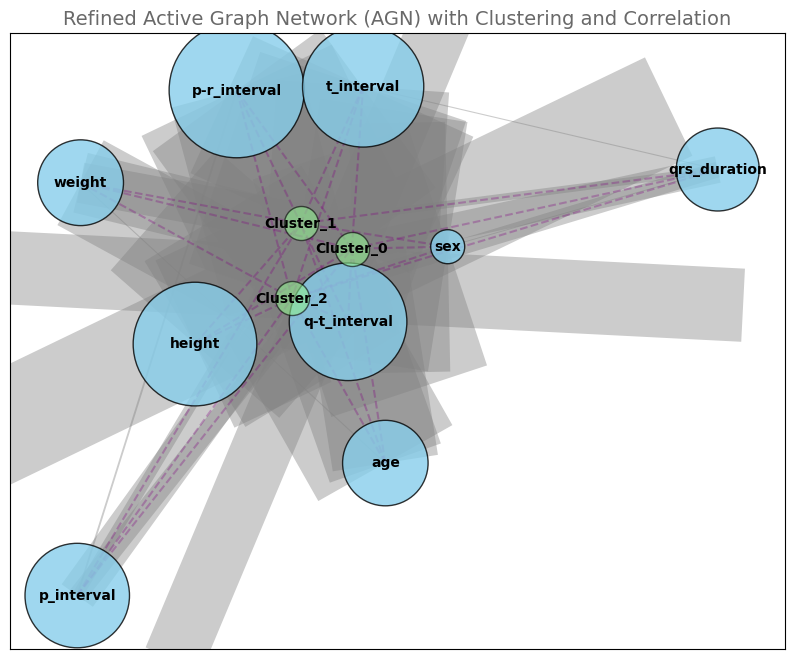

In [4]:
import networkx as nx

# Active Graph Network (AGN) Setup
G_agn = nx.Graph()

# Add feature nodes with attributes (e.g., mean, standard deviation)
for feature in selected_features:
    feature_mean = arrhythmia_df_no_outliers[feature].mean()
    feature_std = arrhythmia_df_no_outliers[feature].std()
    G_agn.add_node(feature, mean=feature_mean, std_dev=feature_std)

# Add cluster nodes and link features to their respective clusters
unique_clusters = arrhythmia_df_no_outliers['cluster'].unique()
for cluster in unique_clusters:
    cluster_name = f"Cluster_{cluster}"
    G_agn.add_node(cluster_name, type='cluster')

    # Link each feature to its respective cluster if it contributes to the cluster pattern
    cluster_data = arrhythmia_df_no_outliers[arrhythmia_df_no_outliers['cluster'] == cluster]
    for feature in selected_features:
        feature_mean_cluster = cluster_data[feature].mean()
        G_agn.add_edge(feature, cluster_name, weight=abs(feature_mean_cluster - feature_mean))

# Add edges between features based on strong correlations
threshold = 0.3
for i, feature1 in enumerate(selected_features):
    for j, feature2 in enumerate(selected_features[i + 1:]):
        corr_value = pearson_corr.loc[feature1, feature2]
        if abs(corr_value) > threshold:
            G_agn.add_edge(feature1, feature2, weight=corr_value, relationship="correlated")

# Adjusted AGN Visualization Code
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G_agn, seed=42)  # Recalculate layout to spread out nodes

# Define node styles
feature_nodes = [n for n in G_agn.nodes if n in selected_features]
cluster_nodes = [n for n in G_agn.nodes if 'Cluster' in n]

# Draw feature nodes with softer colors and sizes based on variability
nx.draw_networkx_nodes(G_agn, pos, nodelist=feature_nodes, node_size=[500 + 200*np.std(arrhythmia_df[feature]) for feature in selected_features], 
                       node_color='skyblue', alpha=0.8, edgecolors='k')

# Draw cluster nodes with a more subtle green and smaller sizes
nx.draw_networkx_nodes(G_agn, pos, nodelist=cluster_nodes, node_size=600, 
                       node_color='lightgreen', alpha=0.6, edgecolors='k')

# Draw correlation edges with thinner, transparent lines
correlation_edges = [(u, v) for u, v, d in G_agn.edges(data=True) if 'weight' in d]
weights = [abs(G_agn[u][v]['weight']) for u, v in correlation_edges]
nx.draw_networkx_edges(G_agn, pos, edgelist=correlation_edges, width=[2 * w for w in weights], 
                       edge_color='gray', alpha=0.4)

# Draw cluster contribution edges with dashed, transparent lines
cluster_edges = [(u, v) for u, v in G_agn.edges if 'Cluster' in u or 'Cluster' in v]
nx.draw_networkx_edges(G_agn, pos, edgelist=cluster_edges, style='dashed', width=1.5, 
                       edge_color='purple', alpha=0.3)

# Draw labels with softer font color
nx.draw_networkx_labels(G_agn, pos, font_size=10, font_weight="bold", font_color="black")

# Set a title with a softer, minimalist font style
plt.title("Refined Active Graph Network (AGN) with Clustering and Correlation", fontsize=14, color="dimgray")
plt.show()

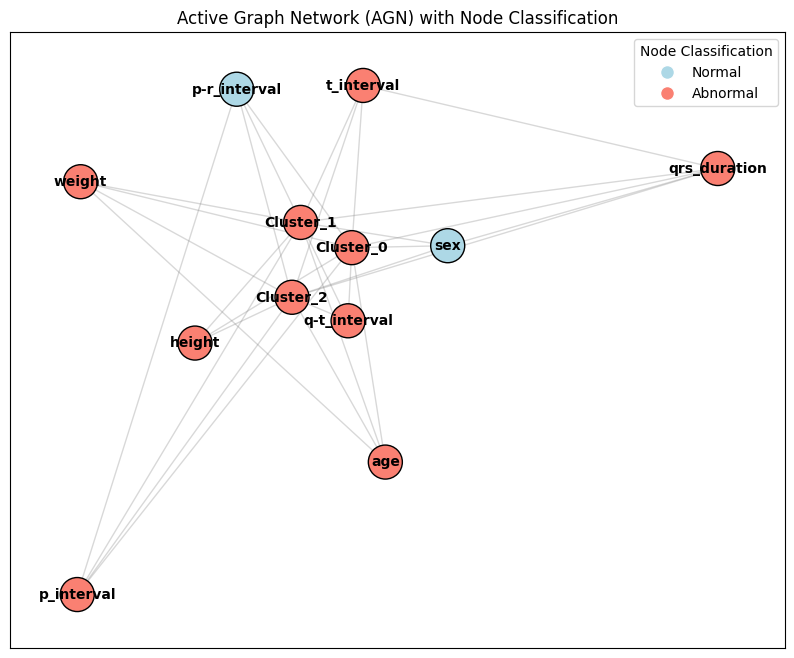

In [5]:
import torch.optim as optim

# Neural Network Definition for Node Classification (Abnormal vs. Normal)
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 2)  # Two classes: Normal, Abnormal

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Step 1: Prepare Node Features
# Use standardized values of selected features as input to the neural network
scaler = StandardScaler()
standardized_features = scaler.fit_transform(arrhythmia_df[selected_features])
node_features = torch.tensor(standardized_features, dtype=torch.float32)

# Step 2: Initialize Model, Loss Function, and Optimizer
model = SimpleNN(input_size=node_features.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# For demonstration purposes, we simulate target labels (0 = Normal, 1 = Abnormal)
# Normally, you'd use actual labels based on domain knowledge or expert classification
target_labels = torch.randint(0, 2, (node_features.shape[0],))

# Training Loop (For demonstration)
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    output = model(node_features)
    loss = criterion(output, target_labels)
    loss.backward()
    optimizer.step()

# Step 3: Predict Classifications for Each Node
with torch.no_grad():
    output = model(node_features)
    predictions = torch.argmax(output, dim=1)  # 0 = Normal, 1 = Abnormal

# Step 4: Assign Classification Result to Nodes in AGN
for idx, node in enumerate(G_agn.nodes()):
    classification = 'Abnormal' if predictions[idx].item() == 1 else 'Normal'
    G_agn.nodes[node]['classification'] = classification

# Step 5: Visualize the Classification Results in AGN
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G_agn, seed=42)

# Draw nodes with color based on classification
color_map = {'Normal': 'lightblue', 'Abnormal': 'salmon'}
node_colors = [color_map[G_agn.nodes[node]['classification']] for node in G_agn.nodes]

nx.draw_networkx_nodes(G_agn, pos, node_size=600, node_color=node_colors, edgecolors='k')
nx.draw_networkx_edges(G_agn, pos, width=1, alpha=0.3, edge_color='gray')
nx.draw_networkx_labels(G_agn, pos, font_size=10, font_weight="bold")

# Add a legend for classifications
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label='Normal', markerfacecolor='lightblue', markersize=10),
                    plt.Line2D([0], [0], marker='o', color='w', label='Abnormal', markerfacecolor='salmon', markersize=10)],
           title="Node Classification")
plt.title("Active Graph Network (AGN) with Node Classification")
plt.show()

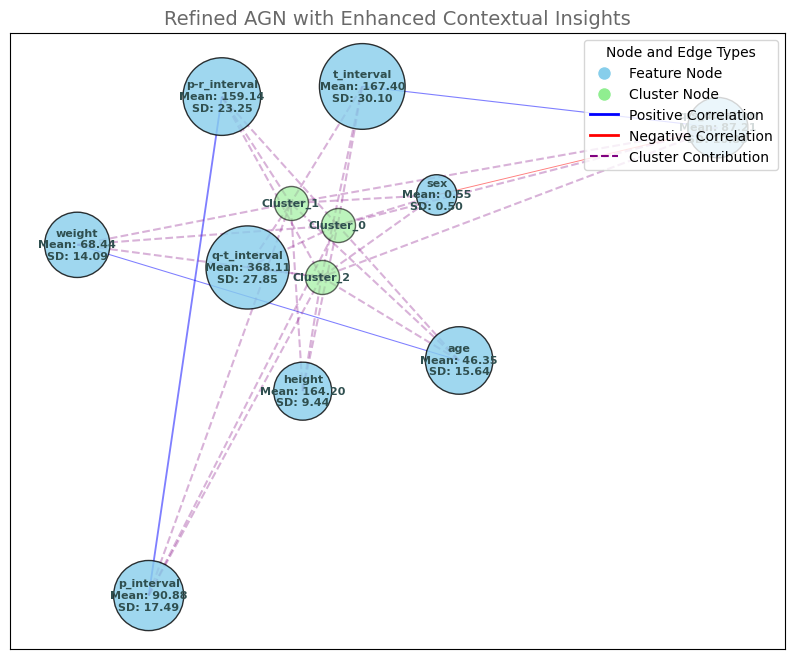

In [6]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# Refine node properties with context-specific information
G_agn = nx.Graph()

# Step 1: Adding feature nodes with mean and std as node attributes
for feature in selected_features:
    feature_mean = arrhythmia_df_no_outliers[feature].mean()
    feature_std = arrhythmia_df_no_outliers[feature].std()
    G_agn.add_node(feature, mean=feature_mean, std_dev=feature_std, node_type="feature")

# Step 2: Adding cluster nodes and linking features to clusters
unique_clusters = arrhythmia_df_no_outliers['cluster'].unique()
for cluster in unique_clusters:
    cluster_name = f"Cluster_{cluster}"
    G_agn.add_node(cluster_name, node_type="cluster")

    # Link features to clusters with edge weights representing contribution to cluster patterns
    cluster_data = arrhythmia_df_no_outliers[arrhythmia_df_no_outliers['cluster'] == cluster]
    for feature in selected_features:
        feature_mean_cluster = cluster_data[feature].mean()
        # Use absolute difference in means as a proxy for feature "contribution"
        G_agn.add_edge(feature, cluster_name, weight=abs(feature_mean_cluster - feature_mean))

# Step 3: Add edges based on correlation with direction indication
threshold = 0.3
for i, feature1 in enumerate(selected_features):
    for j, feature2 in enumerate(selected_features[i + 1:]):
        corr_value = pearson_corr.loc[feature1, feature2]
        if abs(corr_value) > threshold:
            color = 'blue' if corr_value > 0 else 'red'  # Blue for positive, red for negative correlation
            G_agn.add_edge(feature1, feature2, weight=abs(corr_value), relationship="correlated", color=color)

# Visualization Setup
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G_agn, seed=42)

# Node and Edge Styles
feature_nodes = [n for n, attr in G_agn.nodes(data=True) if attr["node_type"] == "feature"]
cluster_nodes = [n for n, attr in G_agn.nodes(data=True) if attr["node_type"] == "cluster"]

# Feature node sizes based on variability, colors based on type
node_sizes = [800 + 100 * G_agn.nodes[feature]['std_dev'] for feature in feature_nodes]
node_colors = ['skyblue' if n in feature_nodes else 'lightgreen' for n in G_agn.nodes()]

# Draw feature nodes
nx.draw_networkx_nodes(G_agn, pos, nodelist=feature_nodes, node_size=node_sizes, node_color='skyblue', alpha=0.8, edgecolors='k')
nx.draw_networkx_nodes(G_agn, pos, nodelist=cluster_nodes, node_size=600, node_color='lightgreen', alpha=0.6, edgecolors='k')

# Draw correlation edges with colors for direction (blue/red)
correlation_edges = [(u, v) for u, v, d in G_agn.edges(data=True) if d.get("relationship") == "correlated"]
edge_colors = [G_agn[u][v]['color'] for u, v in correlation_edges]
edge_weights = [2 * G_agn[u][v]['weight'] for u, v in correlation_edges]
nx.draw_networkx_edges(G_agn, pos, edgelist=correlation_edges, width=edge_weights, edge_color=edge_colors, alpha=0.5)

# Draw cluster contribution edges (dashed purple lines)
cluster_edges = [(u, v) for u, v in G_agn.edges if 'Cluster' in u or 'Cluster' in v]
nx.draw_networkx_edges(G_agn, pos, edgelist=cluster_edges, style='dashed', width=1.5, edge_color='purple', alpha=0.3)

# Node Labels with Additional Insights
labels = {}
for node in G_agn.nodes(data=True):
    if node[1]["node_type"] == "feature":
        # Show mean and std deviation in labels
        labels[node[0]] = f"{node[0]}\nMean: {node[1]['mean']:.2f}\nSD: {node[1]['std_dev']:.2f}"
    else:
        labels[node[0]] = node[0]  # Cluster nodes get simple labels

nx.draw_networkx_labels(G_agn, pos, labels=labels, font_size=8, font_weight="bold", font_color="darkslategray")

# Legend
plt.legend(
    handles=[
        plt.Line2D([0], [0], marker='o', color='w', label='Feature Node', markerfacecolor='skyblue', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='Cluster Node', markerfacecolor='lightgreen', markersize=10),
        plt.Line2D([0], [0], color='blue', lw=2, label='Positive Correlation'),
        plt.Line2D([0], [0], color='red', lw=2, label='Negative Correlation'),
        plt.Line2D([0], [0], linestyle='dashed', color='purple', lw=1.5, label='Cluster Contribution')
    ],
    title="Node and Edge Types", loc="upper right"
)

plt.title("Refined AGN with Enhanced Contextual Insights", fontsize=14, color="dimgray")
plt.show()

In [7]:
# Create synthetic interaction term
arrhythmia_df['qrs_qt_interaction'] = arrhythmia_df['qrs_duration'] * arrhythmia_df['q-t_interval']

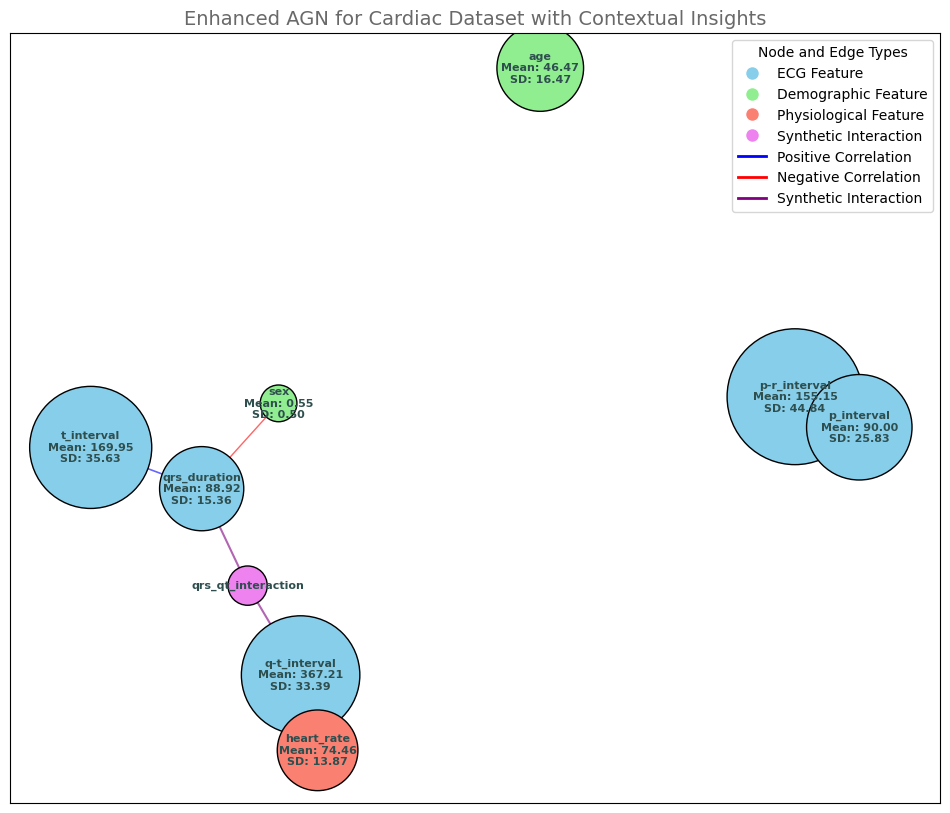

In [8]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure only numeric columns are used for correlation calculation
numeric_df = arrhythmia_df.select_dtypes(include=[np.number])

# Define the cardiac dataset features and types
feature_types = {
    'age': 'Demographic', 
    'sex': 'Demographic', 
    'qrs_duration': 'ECG', 
    'p-r_interval': 'ECG', 
    'q-t_interval': 'ECG', 
    't_interval': 'ECG', 
    'p_interval': 'ECG', 
    'heart_rate': 'Physiological'
}

# Initialize AGN for Enhanced Contextualization
G_cardiac_agn = nx.Graph()

# Add feature nodes with types as attributes
for feature, f_type in feature_types.items():
    if feature in numeric_df.columns:  # Ensure feature is in the numeric dataset
        feature_mean = arrhythmia_df[feature].mean()
        feature_std = arrhythmia_df[feature].std()
        G_cardiac_agn.add_node(feature, type=f_type, mean=feature_mean, std_dev=feature_std)

# Define relationships based on correlation (threshold example: 0.3)
correlation_threshold = 0.3
pearson_corr = numeric_df.corr()  # Calculate correlation only on numeric columns

for feature1 in feature_types:
    for feature2 in feature_types:
        if feature1 != feature2 and feature1 in numeric_df.columns and feature2 in numeric_df.columns:
            corr_value = pearson_corr.loc[feature1, feature2]
            if abs(corr_value) > correlation_threshold:
                color = 'blue' if corr_value > 0 else 'red'
                G_cardiac_agn.add_edge(feature1, feature2, weight=abs(corr_value), color=color)

# Add a synthetic interaction term
arrhythmia_df['qrs_qt_interaction'] = arrhythmia_df['qrs_duration'] * arrhythmia_df['q-t_interval']
G_cardiac_agn.add_node('qrs_qt_interaction', type='Synthetic')
G_cardiac_agn.add_edge('qrs_duration', 'qrs_qt_interaction', weight=0.5, color='purple')
G_cardiac_agn.add_edge('q-t_interval', 'qrs_qt_interaction', weight=0.5, color='purple')

# Visualization
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G_cardiac_agn, seed=42)

# Define node styles based on feature type
node_colors = [
    'skyblue' if G_cardiac_agn.nodes[node]['type'] == 'ECG' else 
    'lightgreen' if G_cardiac_agn.nodes[node]['type'] == 'Demographic' else 
    'salmon' if G_cardiac_agn.nodes[node]['type'] == 'Physiological' else 
    'violet' if G_cardiac_agn.nodes[node]['type'] == 'Synthetic' else 'gray' 
    for node in G_cardiac_agn.nodes
]
node_sizes = [600 + 200 * G_cardiac_agn.nodes[node].get('std_dev', 1) for node in G_cardiac_agn.nodes]

# Draw nodes with labels displaying mean and std deviation
nx.draw_networkx_nodes(G_cardiac_agn, pos, node_color=node_colors, node_size=node_sizes, edgecolors="black")
nx.draw_networkx_labels(
    G_cardiac_agn, pos, labels={node: f"{node}\nMean: {G_cardiac_agn.nodes[node]['mean']:.2f}\nSD: {G_cardiac_agn.nodes[node]['std_dev']:.2f}"
                                if G_cardiac_agn.nodes[node]['type'] != 'Synthetic' else node 
                                for node in G_cardiac_agn.nodes}, 
    font_size=8, font_weight='bold', font_color="darkslategray"
)

edges = [(u, v) for u, v, d in G_cardiac_agn.edges(data=True)]
weights = [d.get('weight', 1) for u, v, d in G_cardiac_agn.edges(data=True)]
colors = [d.get('color', 'gray') for u, v, d in G_cardiac_agn.edges(data=True)]

# Set the edge thickness based on weight
edge_thickness = [3 * w for w in weights]

# Draw edges with the specified colors and thicknesses
nx.draw_networkx_edges(G_cardiac_agn, pos, edgelist=edges, width=edge_thickness, edge_color=colors, alpha=0.6)

# Legends
plt.legend(
    handles=[
        plt.Line2D([0], [0], marker='o', color='w', label='ECG Feature', markerfacecolor='skyblue', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='Demographic Feature', markerfacecolor='lightgreen', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='Physiological Feature', markerfacecolor='salmon', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='Synthetic Interaction', markerfacecolor='violet', markersize=10),
        plt.Line2D([0], [0], color='blue', lw=2, label='Positive Correlation'),
        plt.Line2D([0], [0], color='red', lw=2, label='Negative Correlation'),
        plt.Line2D([0], [0], color='purple', lw=2, label='Synthetic Interaction')
    ],
    title="Node and Edge Types", loc="upper right"
)

plt.title("Enhanced AGN for Cardiac Dataset with Contextual Insights", fontsize=14, color="dimgray")
plt.show()

Feature Importances:
 q-t_interval    0.133501
t_interval      0.133088
weight          0.128545
age             0.126629
qrs_duration    0.124214
p_interval      0.117212
p-r_interval    0.117107
height          0.101537
sex             0.018166
dtype: float64


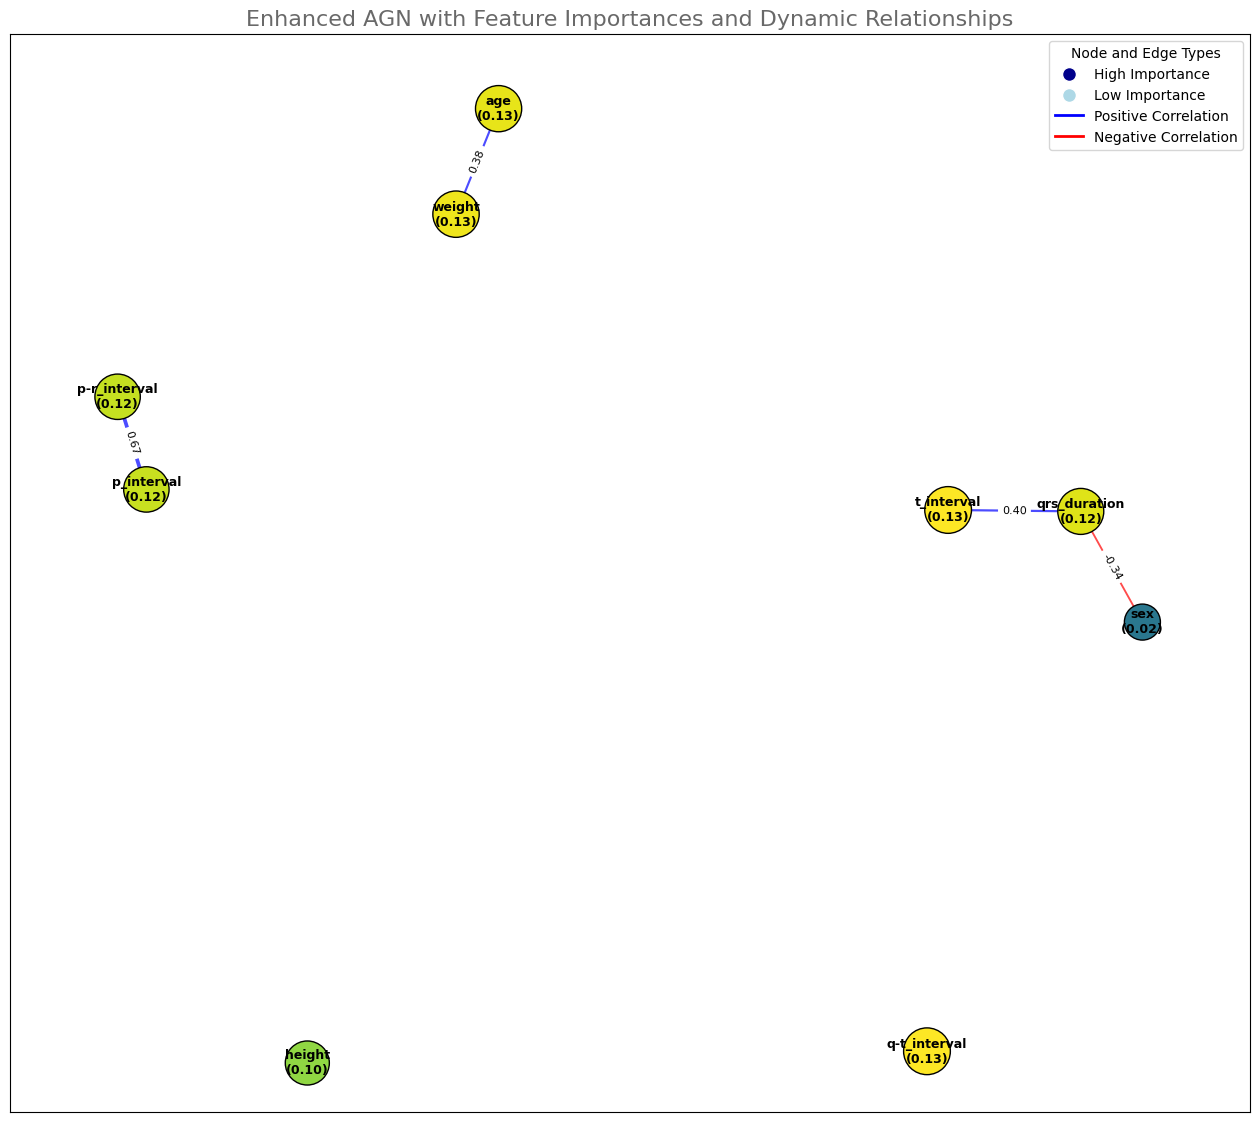

In [9]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# Step 1: Data Preparation
scaler = StandardScaler()
arrhythmia_scaled = scaler.fit_transform(arrhythmia_df[selected_features])

# Step 1.2: Train a model to get feature importances
X = arrhythmia_scaled
y = arrhythmia_df['diagnosis'].round().astype(int)
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X, y)

# Retrieve feature importances and create a mapping
feature_importances = pd.Series(rf_model.feature_importances_, index=selected_features).sort_values(ascending=False)
print("Feature Importances:\n", feature_importances)

# Step 2: Enhanced AGN with Dynamic Relationships
G_agn_dynamic = nx.Graph()

# Add nodes with size and color based on feature importance
for feature in selected_features:
    importance = feature_importances.get(feature, 0)
    G_agn_dynamic.add_node(
        feature, 
        importance=importance, 
        size=600 + 4000 * importance,  # More differentiation in size
        color=plt.cm.viridis(0.3 + 0.7 * importance / feature_importances.max())  # Enhanced color gradient
    )

# Step 3: Dynamic Relationships Based on Correlations
correlation_threshold = 0.25
correlation_matrix = pd.DataFrame(arrhythmia_scaled, columns=selected_features).corr()

for i, feature1 in enumerate(selected_features):
    for feature2 in selected_features[i+1:]:
        corr_value = correlation_matrix.loc[feature1, feature2]
        if abs(corr_value) >= correlation_threshold:
            color = 'blue' if corr_value > 0 else 'red'
            G_agn_dynamic.add_edge(
                feature1, feature2, 
                weight=abs(corr_value), 
                color=color,
                label=f"{corr_value:.2f}"  # Adding correlation as edge label
            )

# Step 4: Visualization with Enhanced Scaling and Layout Adjustments
plt.figure(figsize=(16, 14))
pos = nx.spring_layout(G_agn_dynamic, k=0.4, seed=42)  # Increase k for more spacing

# Define node sizes, colors, and labels
node_sizes = [G_agn_dynamic.nodes[node]["size"] for node in G_agn_dynamic.nodes]
node_colors = [G_agn_dynamic.nodes[node]["color"] for node in G_agn_dynamic.nodes]
node_labels = {node: f"{node}\n({importance:.2f})" for node, importance in feature_importances.items()}

# Define edge thickness and colors
edges = [(u, v) for u, v, d in G_agn_dynamic.edges(data=True)]
weights = [d.get('weight', 1) for _, _, d in G_agn_dynamic.edges(data=True)]
colors = [d.get('color', 'gray') for _, _, d in G_agn_dynamic.edges(data=True)]
edge_thickness = [4 * w for w in weights]

# Draw nodes, edges, and labels
nx.draw_networkx_nodes(G_agn_dynamic, pos, node_color=node_colors, node_size=node_sizes, edgecolors="black")
nx.draw_networkx_labels(G_agn_dynamic, pos, labels=node_labels, font_size=9, font_weight="bold")  # Removed 'ha'
nx.draw_networkx_edges(G_agn_dynamic, pos, edgelist=edges, width=edge_thickness, edge_color=colors, alpha=0.7)

# Add edge labels for correlation values
edge_labels = nx.get_edge_attributes(G_agn_dynamic, 'label')
nx.draw_networkx_edge_labels(G_agn_dynamic, pos, edge_labels=edge_labels, font_size=8, label_pos=0.5)

# Legends for color coding and relationship types
plt.legend(
    handles=[
        plt.Line2D([0], [0], marker='o', color='w', label='High Importance', markerfacecolor='darkblue', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='Low Importance', markerfacecolor='lightblue', markersize=10),
        plt.Line2D([0], [0], color='blue', lw=2, label='Positive Correlation'),
        plt.Line2D([0], [0], color='red', lw=2, label='Negative Correlation')
    ],
    title="Node and Edge Types", loc="upper right"
)

plt.title("Enhanced AGN with Feature Importances and Dynamic Relationships", fontsize=16, color="dimgray")
plt.show()

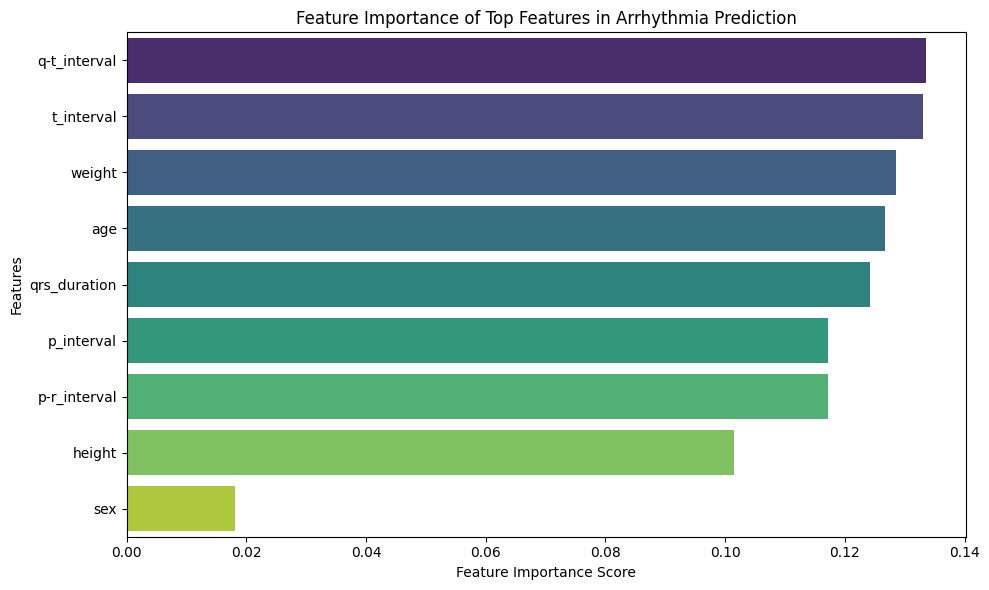

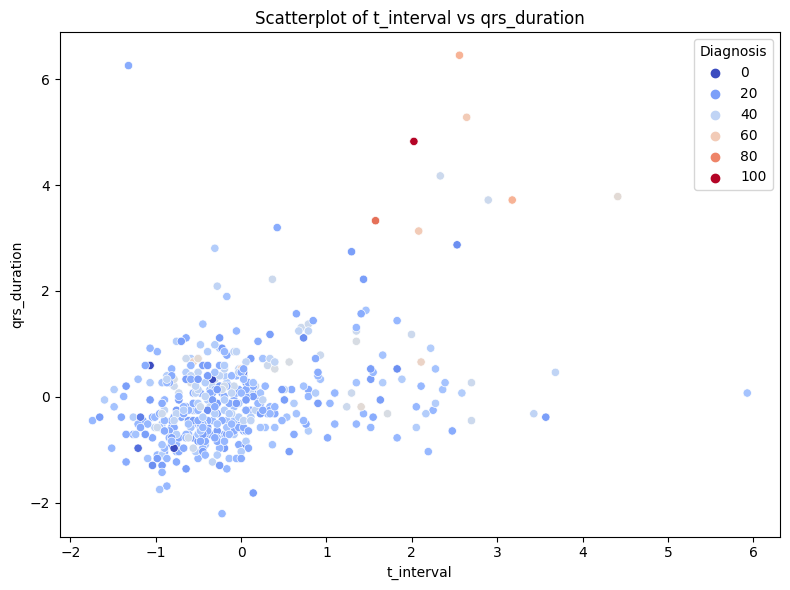

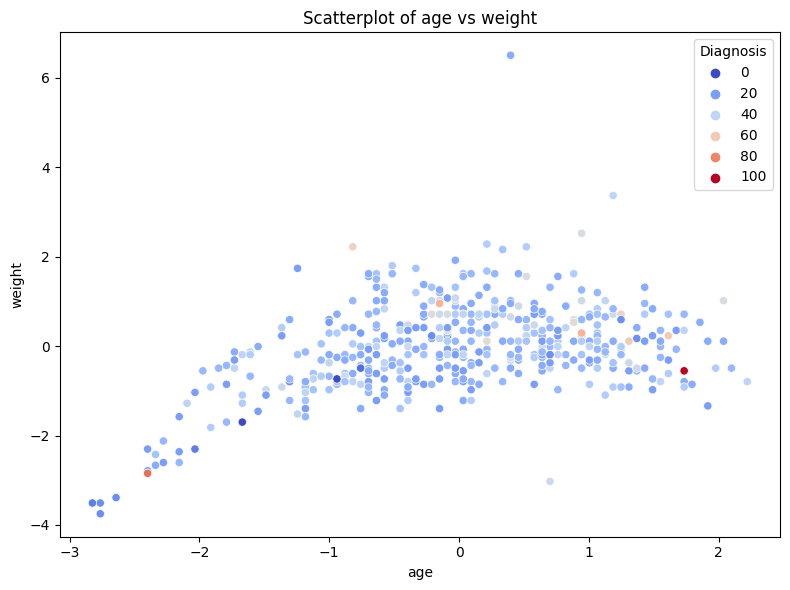

/tmp/ipykernel_23/2227826935.py:36: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=arrhythmia_df_scaled, x=feature, y='diagnosis', palette="coolwarm")


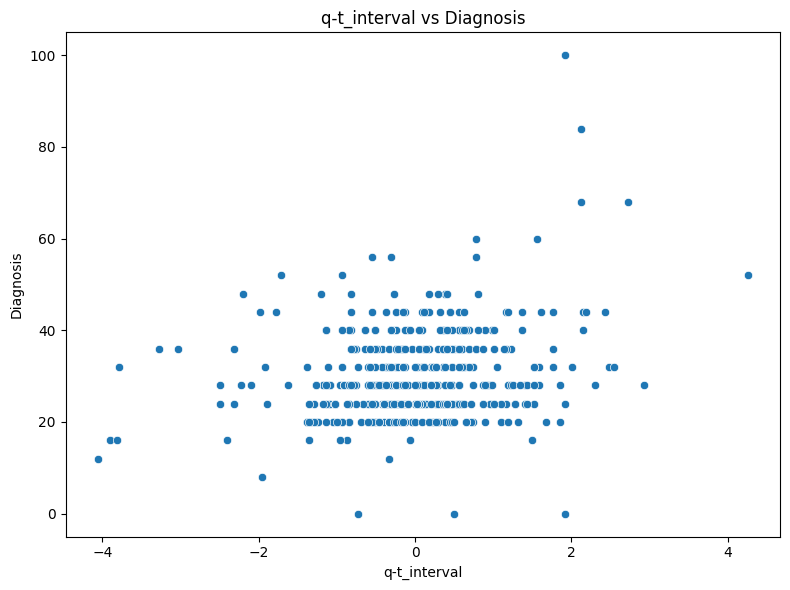

/tmp/ipykernel_23/2227826935.py:36: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=arrhythmia_df_scaled, x=feature, y='diagnosis', palette="coolwarm")


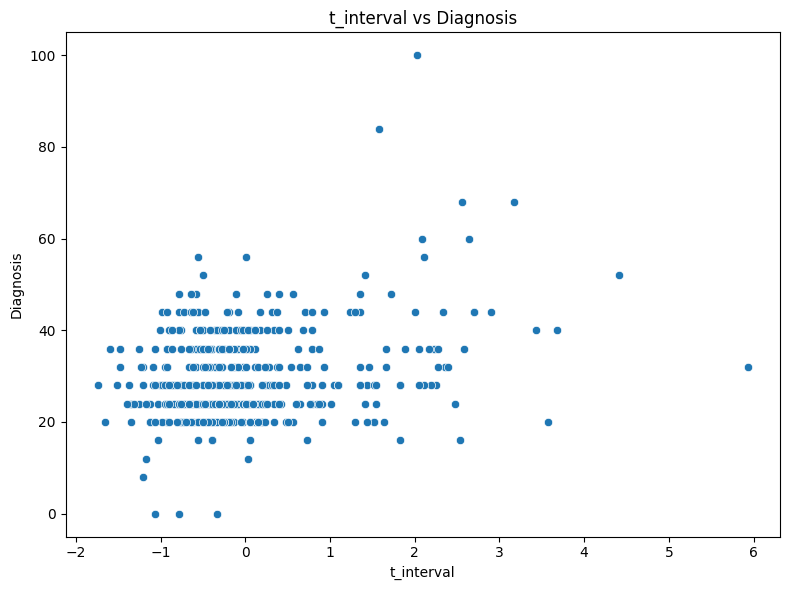

/tmp/ipykernel_23/2227826935.py:36: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=arrhythmia_df_scaled, x=feature, y='diagnosis', palette="coolwarm")


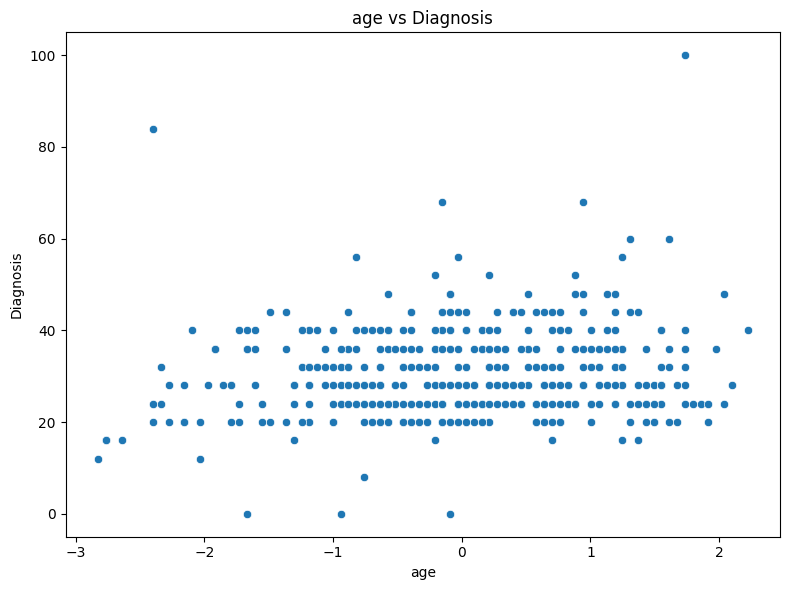

/tmp/ipykernel_23/2227826935.py:36: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=arrhythmia_df_scaled, x=feature, y='diagnosis', palette="coolwarm")


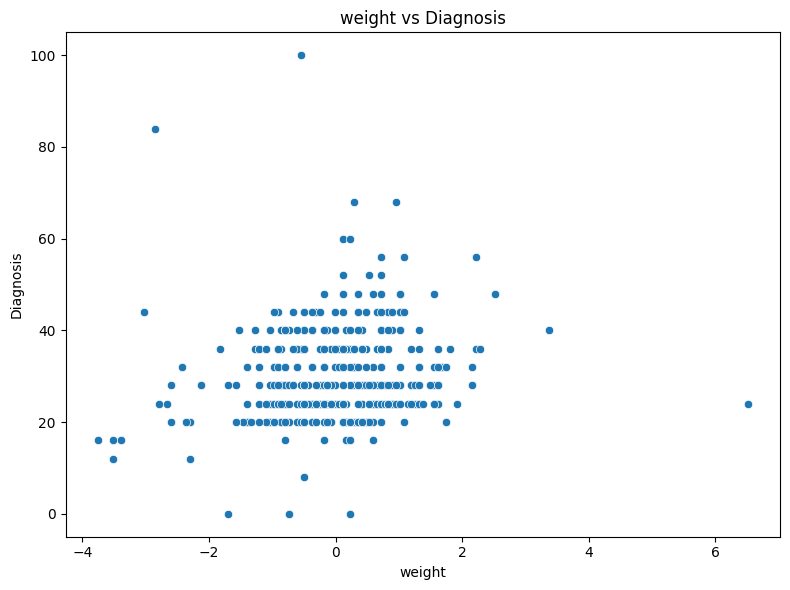

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert scaled data back to a DataFrame for easier plotting
arrhythmia_df_scaled = pd.DataFrame(arrhythmia_scaled, columns=selected_features)
arrhythmia_df_scaled['diagnosis'] = y  # Add diagnosis for plotting

# Plot 1: Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.values, y=feature_importances.index, palette="viridis")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance of Top Features in Arrhythmia Prediction")
plt.tight_layout()
plt.show()

# Plot 2: Scatterplot of Highly Correlated Feature Pairs
# Adjust feature pairs based on your specific findings
highly_correlated_pairs = [('t_interval', 'qrs_duration'), ('age', 'weight')]  # Example pairs

for (feature1, feature2) in highly_correlated_pairs:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=arrhythmia_df_scaled, x=feature1, y=feature2, hue="diagnosis", palette="coolwarm")
    plt.title(f"Scatterplot of {feature1} vs {feature2}")
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.legend(title="Diagnosis")
    plt.tight_layout()
    plt.show()

# Plot 3: Scatterplot of Top Features vs. Diagnosis
top_features = ['q-t_interval', 't_interval', 'age', 'weight']  # Example top features

for feature in top_features:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=arrhythmia_df_scaled, x=feature, y='diagnosis', palette="coolwarm")
    plt.title(f"{feature} vs Diagnosis")
    plt.xlabel(feature)
    plt.ylabel("Diagnosis")
    plt.tight_layout()
    plt.show()